In [3]:
import apimoex
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Скачиваем цены на акции

C:\Users\Ваня\AppData\Local\Temp\ipykernel_6248\2439055059.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  presence_map = presence_map.applymap(lambda x: 1 if x > 0 else 0)


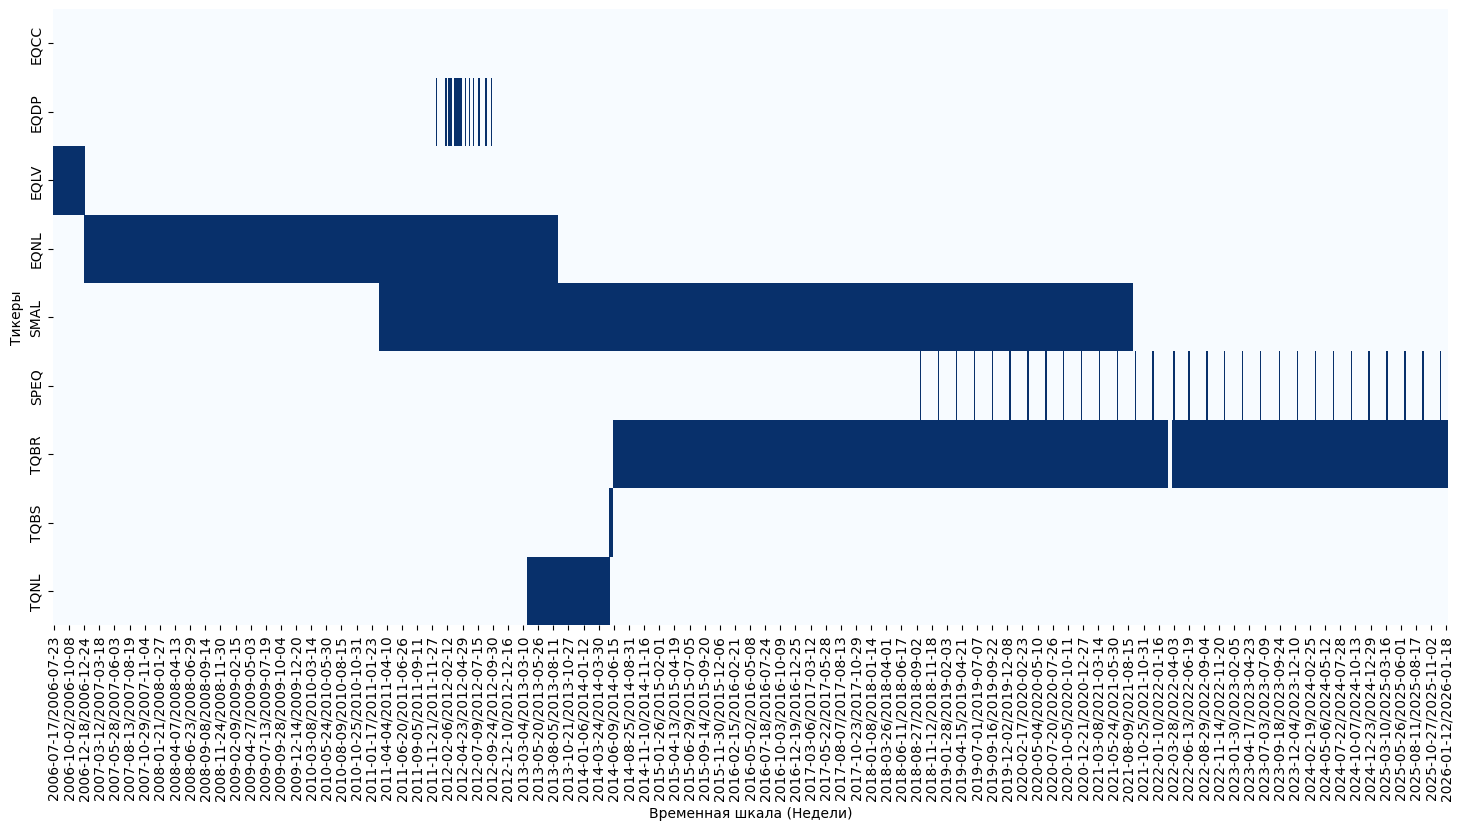

In [4]:
df = pd.read_csv('../data/1-raw/sentiment.csv')
df['time'] = pd.to_datetime(df['date'])
start_date, end_date = min(df['date']), max(df['date'])

def get_history(company_name="ROSN"):
    with requests.Session() as session:
        # Указываем тикер, рынок (shares) и режим торгов (tqbr)
        data = apimoex.get_market_history(
            session, 
            company_name, 
            start=start_date, 
            end=end_date,
        )
        prices = pd.DataFrame(data)
        prices['TRADEDATE'] = pd.to_datetime(prices['TRADEDATE'])
        return prices


prices = get_history()
presence_map = prices.pivot_table(index='BOARDID', 
                              columns=pd.to_datetime(prices['TRADEDATE']).dt.to_period('W'), 
                              values='CLOSE', # любой числовой столбец
                              aggfunc='count').fillna(0)

presence_map = presence_map.applymap(lambda x: 1 if x > 0 else 0)
plt.figure(figsize=(18, 8))
sns.heatmap(presence_map, cmap="Blues", cbar=False, yticklabels=True)
plt.xlabel('Временная шкала (Недели)')
plt.ylabel('Тикеры')
plt.show()

In [93]:
tqbr_start = prices[prices['BOARDID'] == 'TQBR']['TRADEDATE'].min()

part1 = prices[(prices['BOARDID'] == 'EQBR') & (prices['TRADEDATE'] <= tqbr_start)]
part2 = prices[(prices['BOARDID'] == 'TQBR') & (prices['TRADEDATE'] > tqbr_start)]

final_df = pd.concat([part1, part2]).sort_values('TRADEDATE')
prices = final_df
prices = prices.drop('BOARDID', axis=1)
prices.rename(columns={'TRADEDATE': 'date', 'CLOSE': 'close', 'VOLUME': 'volume', 'VALUE': 'value'}, inplace=True)

Аггрегируем исходный столбец по дням

In [94]:
df['date'] = pd.to_datetime(df['date'])
df_aggregated = df.groupby(df['date'].dt.date)['sentiment'].value_counts().unstack(fill_value=0)
df_aggregated['views'] = df.groupby(df['date'].dt.date)['views'].aggregate("sum")
df_aggregated['sentiment_score'] = (df_aggregated['positive'] - df_aggregated['negative']) / (df_aggregated['positive'] + df_aggregated['negative'] + 0.1 * df_aggregated['neutral'])
df_aggregated = df_aggregated.reset_index()
df_aggregated['date'] = pd.to_datetime(df_aggregated['date'])

In [95]:
merged = pd.merge(df_aggregated, prices, how='left', on='date')

In [96]:
groups = merged['close'].notna()[::-1].cumsum()[::-1]
cols_to_fix = ["sentiment_score", "views", "negative", "neutral", "positive"]
merged[cols_to_fix] = merged.groupby(groups)[cols_to_fix].transform('sum')
merged.dropna(inplace=True)

Создание дополнительных признаков

In [ ]:
merged['return'] = (merged['close'] - merged['close'].shift(1)) / merged['close']
merged.dropna(inplace=True)
merged['rolling_mean_7'] = merged['return'].rolling(7).mean()
merged['rolling_mean_14'] = merged['return'].rolling(14).mean()
merged['rolling_std_7'] = merged['return'].rolling(7).std()
merged['rolling_std_14'] = merged['return'].rolling(14).std()

# merged['rolling_mean_7'] = merged['rolling_mean_7'].fillna(merged['close'])
# merged['rolling_mean_14'] = merged['rolling_mean_14'].fillna(merged['close'])
# merged['rolling_std_7'] = merged['close'].fillna(1)
# merged['rolling_std_14'] = merged['close'].fillna(1)

merged.dropna(inplace=True)

merged['day'] = merged['date'].dt.day
merged['month'] = merged['date'].dt.month
merged['year'] = merged['date'].dt.year

In [98]:
processed = merged.drop(columns=['date', 'negative', 'positive', 'value', 'neutral'])
processed.to_csv('../data/2-processed/processed.csv', index=False)

Проведем анализ важности и посмотрим, что еще можно выкинуть

In [99]:
from xgboost import XGBRegressor, plot_importance
from sklearn.preprocessing import MinMaxScaler

features = [
    'sentiment_score', 'volume',  
    'day', 'month', 
]

merged = pd.read_csv('../data/2-processed/processed.csv')

n = int(len(merged) * 0.8)
X = merged[features].iloc[n:]
y = merged['return'].iloc[n:]

scaler = MinMaxScaler()
scaler.fit(X, y)
X_sc = scaler.transform(X)

model = XGBRegressor()
model.fit(X, y)

plot_importance(model, importance_type='gain', max_num_features=10)
plt.plot()
importance_scores = model.get_booster().get_score(importance_type='gain')

In [100]:
merged['close'].rolling(7).std()

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
2890    3.563873
2891    4.065681
2892    3.601207
2893    3.571731
2894    3.499813
Name: close, Length: 2895, dtype: float64

<Axes: >

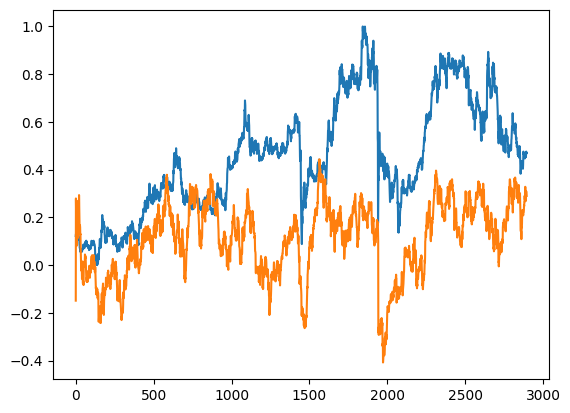

In [101]:
((merged['close'] - merged['close'].min()) / (merged['close'].max() - merged['close'].min())).plot()
merged['sentiment_score'].ewm(alpha=0.05).mean().plot()

In [ ]:
from datetime import datetime

rosn = get_history("ROSN")
sber = get_history("SBER")

rosn = rosn[rosn['BOARDID'] == 'TQBR']
sber = sber[sber['BOARDID'] == 'TQBR']

sber = sber[pd.to_datetime(sber['TRADEDATE']) > datetime(2014, 6, 10)]

sber.set_index('TRADEDATE', inplace=True)
rosn.set_index('TRADEDATE', inplace=True)

<Axes: title={'center': 'Котировки SBER'}, xlabel='Дата', ylabel='Цена'>

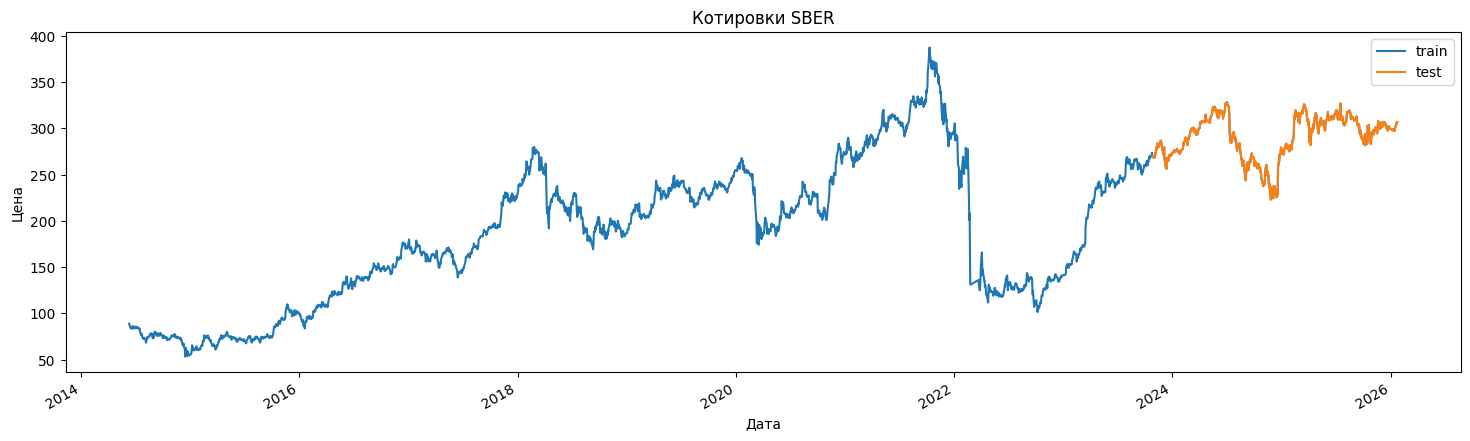

In [31]:
train_size_sber = int(0.8 * len(sber))
sber['CLOSE'].dropna().rename("train").plot(xlabel="Дата", ylabel='Цена', figsize=(18, 5), title='Котировки SBER', legend=True)
sber['CLOSE'].dropna().rename("test").iloc[train_size_sber:].plot(xlabel="Дата", ylabel='Цена', figsize=(18, 5), legend=True)

<Axes: title={'center': 'Котировки ROSN'}, xlabel='Дата', ylabel='Цена'>

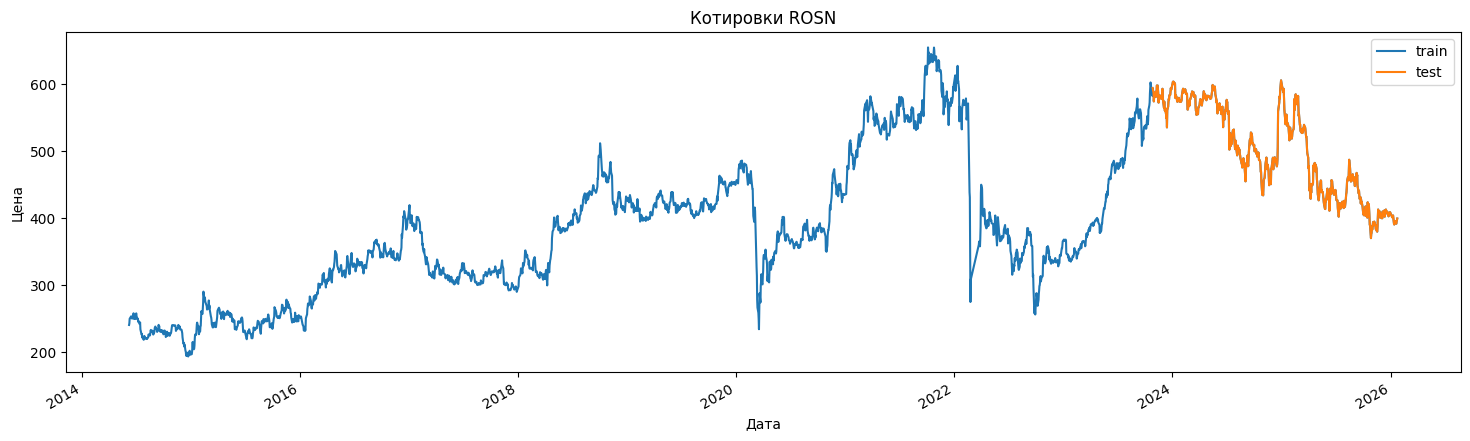

In [34]:
train_size_rosn = int(0.8 * len(rosn))
rosn['CLOSE'].dropna().rename("train").plot(xlabel="Дата", ylabel='Цена', figsize=(18, 5), legend=True)
rosn['CLOSE'].dropna().rename("test").iloc[train_size_rosn:].plot(xlabel="Дата", ylabel='Цена', figsize=(18, 5), title='Котировки ROSN', legend=True)

BOARDID  TRADEDATE   CLOSE    VOLUME         VALUE
3853     TQBR 2014-06-09  240.36   6373420  1.527092e+09
3856     TQBR 2014-06-10  242.80   5042580  1.218261e+09
3859     TQBR 2014-06-11  249.66  12959310  3.186089e+09
3862     TQBR 2014-06-16  253.30  19174760  4.816129e+09
3865     TQBR 2014-06-17  251.59   7504200  1.894840e+09
...       ...        ...     ...       ...           ...
10318    TQBR 2026-01-19  392.10   2410433  9.514372e+08
10319    TQBR 2026-01-20  391.80   1937402  7.589975e+08
10320    TQBR 2026-01-21  395.55   2391404  9.435676e+08
10321    TQBR 2026-01-22  397.00   4402446  1.754531e+09
10322    TQBR 2026-01-23  399.45   2801970  1.115987e+09

[2939 rows x 5 columns]